In [48]:
import os
os.environ["THEANO_FLAGS"] = "device=cpu,floatX=float32"

In [49]:
import os
import sys
import traceback
import functools
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sbn
import deepdish as dd
import theano
import theano.tensor as T
import lasagne
from IPython import display
from tqdm import tqdm
import neural_networks as nn
from music_utils import generateSequence
from nnet_utils import get_next_batch_rnn
%matplotlib inline

import pdb

In [50]:
# generate data for interval major and minor    
int_maj = [0, 2, 2, 1, 2, 2, 2]
int_min = [0, 2, 1, 2, 2, 1, 2]
min_len = 2
max_len = len(int_maj)
input_maj, target_maj, masks_maj = generateSequence(int_maj, min_len, max_len, clip=True)
input_min, target_min, masks_min = generateSequence(int_min, min_len, max_len, clip=True)

In [51]:
d_batch_size = 128
g_batch_size = 128
epoch_size = len(input_maj)
n_timesteps = 7
n_features = 12
n_conditions = 2
n_labels = 3
temperature = 16

In [52]:
input_data = np.concatenate((input_maj, input_min)).astype(np.float32)
target_data = np.concatenate((target_maj, target_min)).astype(np.float32)
masks_data = np.concatenate((masks_maj, masks_min)).astype(np.int32)

cond_data = np.zeros((2*len(masks_maj), n_features, n_conditions), dtype=np.float32)
cond_data[:len(masks_maj), :, 0] = 1                            
cond_data[len(masks_maj):, :, 1] = 1                            
                           
lbls_data = np.zeros((2*len(masks_maj), n_labels), dtype=np.float32)
lbls_data[:len(masks_maj), 0] = 1                            
lbls_data[len(masks_maj):, 1] = 1                            

In [53]:
def output_nonlinearity(data, temperature=1):
    return T.clip(lasagne.nonlinearities.softmax(lasagne.nonlinearities.linear(data / temperature)), 1e-7, 1 - 1e-7)
    
softmax_temperature = functools.partial(output_nonlinearity, temperature=temperature)

In [67]:
d_specs = {'batch_size': d_batch_size,
           'epoch_size': epoch_size,
           'input_shape': (None, None, n_features),
           'mask_shape': (None, None),
           'n_output_units': n_labels
           'n_units': 32,
           'n_hidden': 32,
           'grad_clip': 100.,
           'init': lasagne.init.HeUniform(),
           'non_linearities': (
              lasagne.nonlinearities.tanh,  # feedforward
              lasagne.nonlinearities.tanh,  # feedbackward
              softmax_temperature),  # apply sotfmax with temperature
           'learning_rate': 0.01,           
           'learning_rate_pre': 0.1,                      
          }

g_specs = {'batch_size': g_batch_size,
           'epoch_size': epoch_size,
           'input_shape': (None, None, n_features),
           'noise_shape': (None, None, n_features),
           'cond_shape': (None, None, n_conditions,
           'mask_shape': (None, None),
           'n_output_units': n_features,
           'n_units': 32,
           'n_hidden': 32 ,
           'grad_clip': 100.,
           'init': lasagne.init.HeUniform(),
           'non_linearities': (
              lasagne.nonlinearities.tanh,  # feedforward
              lasagne.nonlinearities.tanh,  # feedbackward
              softmax_temperature),  # apply sotfmax with temperature
           'learning_rate': 0.005,
          }

In [68]:
# declare theano variables
d_in_X = T.ftensor3('ddata')
d_in_M = T.imatrix('dismask')
g_in_D = T.ftensor3('gdata')
g_in_Z = T.ftensor3('noise')
g_in_C = T.ftensor3('condition')
g_in_M = T.imatrix('genmask')

In [69]:
def build_discriminator(params):
    # input layers
    l_in = lasagne.layers.InputLayer(shape=d_specs['input_shape'], name='d_in') 
    l_mask = lasagne.layers.InputLayer(shape=d_specs['mask_shape'], name='d_mask')

    # recurrent layers for bidirectional network
    l_forward = lasagne.layers.RecurrentLayer(
        l_in, d_specs['n_units'], grad_clipping=d_specs['grad_clip'],
        W_in_to_hid=d_specs['init'], W_hid_to_hid=d_specs['init'],
        nonlinearity=d_specs['non_linearities'][0], only_return_final=True, mask_input=l_mask)
    l_backward = lasagne.layers.RecurrentLayer(
        l_in, d_specs['n_units'], grad_clipping=d_specs['grad_clip'],
        W_in_to_hid=d_specs['init'], W_hid_to_hid=d_specs['init'],        
        nonlinearity=d_specs['non_linearities'][1], only_return_final=True, mask_input=l_mask,
        backwards=True)

    # concatenate output of forward and backward layers
    l_concat = lasagne.layers.ConcatLayer([l_forward, l_backward])

    # output layer
    l_out = lasagne.layers.DenseLayer(
        l_concat, num_units=d_specs['n_output_units'], nonlinearity=d_specs['non_linearities'][2])

    class Discriminator:
        def __init__(self, l_in, l_mask, l_out):
            self.l_in = l_in
            self.l_mask = l_mask
            self.l_out = l_out
            
    return Discriminator(l_in, l_mask, l_out)

In [70]:
def build_generator(params):
    # input layers
    l_in = lasagne.layers.InputLayer(shape=g_specs['input_shape'], input_var=g_in_D, name='g_in')
    l_noise = lasagne.layers.InputLayer(shape=g_specs['noise_shape'], input_var=g_in_Z, name='g_noise')
    l_cond = lasagne.layers.InputLayer(shape=g_specs['cond_shape'], input_var=g_in_C, name='g_cond')
    l_mask = lasagne.layers.InputLayer(shape=g_specs['mask_shape'], input_var=g_in_M, name='g_mask')

    # recurrent layers for bidirectional network
    l_forward_data = lasagne.layers.RecurrentLayer(
        l_in, g_specs['n_units'], grad_clipping=g_specs['grad_clip'],
        W_in_to_hid=g_specs['init'], W_hid_to_hid=g_specs['init'],
        nonlinearity=lasagne.nonlinearities.linear, only_return_final=True, mask_input=l_mask)
    l_forward_noise = lasagne.layers.RecurrentLayer(
        l_noise, g_specs['n_units'], b=lasagne.init.Constant(0.), grad_clipping=g_specs['grad_clip'], 
        W_in_to_hid=g_specs['init'], W_hid_to_hid=g_specs['init'],        
        nonlinearity=lasagne.nonlinearities.linear, only_return_final=True, mask_input=l_mask)
    l_forward_cond = lasagne.layers.RecurrentLayer(
        l_cond, g_specs['n_units'], b=lasagne.init.Constant(0.), grad_clipping=g_specs['grad_clip'], 
        W_in_to_hid=g_specs['init'], W_hid_to_hid=g_specs['init'],        
        nonlinearity=lasagne.nonlinearities.linear, only_return_final=True, mask_input=l_mask)
    l_backward_data = lasagne.layers.RecurrentLayer(
        l_in, g_specs['n_units'], grad_clipping=g_specs['grad_clip'],
        W_in_to_hid=g_specs['init'], W_hid_to_hid=g_specs['init'],        
        nonlinearity=lasagne.nonlinearities.linear, only_return_final=True,
        backwards=True, mask_input=l_mask)
    l_backward_noise = lasagne.layers.RecurrentLayer(
        l_noise, g_specs['n_units'], b=lasagne.init.Constant(0.), grad_clipping=g_specs['grad_clip'],
        W_in_to_hid=g_specs['init'], W_hid_to_hid=g_specs['init'],        
        nonlinearity=lasagne.nonlinearities.linear, only_return_final=True,
        backwards=True, mask_input=l_mask)    
    l_backward_cond = lasagne.layers.RecurrentLayer(
        l_cond, g_specs['n_units'], b=lasagne.init.Constant(0.), grad_clipping=g_specs['grad_clip'],
        W_in_to_hid=g_specs['init'], W_hid_to_hid=g_specs['init'],        
        nonlinearity=lasagne.nonlinearities.linear, only_return_final=True,
        backwards=True, mask_input=l_mask)

    # sum linearities of data and condition on forward and and backward recurrent layers
    l_forward_sum = lasagne.layers.ElemwiseSumLayer([l_forward_data, l_forward_noise, l_forward_cond])
    l_backward_sum = lasagne.layers.ElemwiseSumLayer([l_backward_data, l_backward_noise, l_backward_cond])

    # apply nonlinearity to forward and backward recurrent layers
    l_forward_nonlinearity = lasagne.layers.NonlinearityLayer(l_forward_sum, 
        nonlinearity=g_specs['non_linearities'][0])
    l_backward_nonlinearity = lasagne.layers.NonlinearityLayer(l_backward_sum, 
        nonlinearity=g_specs['non_linearities'][1])

    # concatenate output of forward and backward layers
    l_concat = lasagne.layers.ConcatLayer(
        [l_forward_nonlinearity, l_backward_nonlinearity])

    # output layer where time is collapsed into one dimension
    l_out = lasagne.layers.DenseLayer(
        l_concat, num_units=g_specs['n_output_units'], nonlinearity=g_specs['non_linearities'][2])    


    class Generator:
        def __init__(self, l_in, l_noise, l_cond, l_mask, l_out):
            self.l_in = l_in
            self.l_noise = l_noise
            self.l_cond = l_cond
            self.l_mask = l_mask
            self.l_out = l_out

    return Generator(l_in, l_noise, l_cond, l_mask, l_out)

In [71]:
def build_training(discriminator, generator, d_specs, g_specs):
    # get variables from discrimiator and generator
    d_params = lasagne.layers.get_all_params(discriminator.l_out, trainable=True)
    g_params = lasagne.layers.get_all_params(generator.l_out, trainable=True)
    
    d_labels = T.fmatrix('d_label')
    g_labels = T.fmatrix('g_label')    

    d_lr = T.scalar(name='d_lr')
    g_lr = T.scalar(name='g_lr')

    # G(z)
    g_z = lasagne.layers.get_output(generator.l_out,
                                    inputs={generator.l_in: g_in_D,
                                            generator.l_noise: g_in_Z,
                                            generator.l_cond: g_in_C,
                                            generator.l_mask: g_in_M})

    # create proper G(z) mask
    g_in_M_idx = g_in_M.sum(axis=1)
    g_in_M_alt = theano.clone(g_in_M) 
    g_in_M_alt = T.set_subtensor(g_in_M_alt[T.arange(g_in_M_alt.shape[0]), g_in_M_idx], 
                                 T.ones_like(g_in_M_alt[:, 0]))

    # create proper G(z)
    g_in_D_alt = theano.clone(g_in_D)
    g_in_D_alt = T.set_subtensor(g_in_D_alt[T.arange(g_in_D_alt.shape[0]), g_in_M_idx], 
                                 g_z)

    # D(G(z))
    d_g_z = lasagne.layers.get_output(
        discriminator.l_out,         
        inputs={discriminator.l_in: g_in_D_alt, 
                discriminator.l_mask: g_in_M_alt})

    g_loss = lasagne.objectives.categorical_crossentropy(1 - d_g_z, g_labels)        
    g_loss = g_loss.mean()

    g_updates = lasagne.updates.adagrad(g_loss, g_params, g_lr)
    g_train_fn = theano.function(inputs=[g_in_D, g_in_Z, g_in_C, g_in_M, g_labels, g_lr],
                                 outputs=g_loss, 
                                 updates=g_updates)
    g_sample_fn = theano.function(inputs=[g_in_D, g_in_Z, g_in_C, g_in_M],
                                  outputs=g_z)

    # D(x)
    d_x = lasagne.layers.get_output(discriminator.l_out,
                                    inputs={discriminator.l_in: d_in_X, 
                                            discriminator.l_mask: d_in_M})
  
    d_x_loss = lasagne.objectives.categorical_crossentropy(d_x, d_labels)
    d_g_z_loss = lasagne.objectives.categorical_crossentropy(d_g_z, g_labels)
    d_loss = d_x_loss + d_g_z_loss
    d_loss = d_loss.mean()    
    
    d_updates = lasagne.updates.adagrad(d_loss, d_params, d_lr)
    d_train_fn = theano.function(
        inputs=[d_in_X, d_in_M, g_in_D, g_in_Z, g_in_C, g_in_M, d_labels, g_labels, d_lr],
        outputs=[d_loss, d_x_loss, d_g_z_loss, d_x, d_g_z, g_in_D_alt], 
        updates=d_updates) 

    d_predict_fn = None

#   d_predict_fn = theano.function(
#        inputs=[d_in_X, d_in_M],
#        outputs=lasagne.layers.get_output(discriminator[2],
#                                          inputs={discriminator[0]: d_in_X, 
#                                                  discriminator[1]: d_in_M}))

    return d_train_fn, d_predict_fn, g_train_fn, g_sample_fn

In [72]:
def sample_generator_batch(batch_size, inputs, conds, masks):
    excerpt = np.random.permutation(len(inputs))[:batch_size]
    # create random noise
    noises = np.random.normal(size=inputs[excerpt].shape).astype('float32') 
    # create labels
    lbls = np.zeros((batch_size, conds.shape[2]+1), dtype=np.float32)
    lbls[:, n_conditions] = 1
    
    return inputs[excerpt], noises, conds[excerpt], masks[excerpt], lbls


def sample_data_batch(batch_size, inputs, targets, masks, labels, conds=None):
    excerpt = np.random.permutation(len(inputs))[:batch_size]
    if conds is None:
        return inputs[excerpt], targets[excerpt], masks[excerpt], labels[excerpt]
    else:
        return inputs[excerpt], targets[excerpt], conds[excerpt], masks[excerpt], labels[excerpt]

In [73]:
discriminator = build_discriminator(d_specs)
generator = build_generator(g_specs)

In [74]:
d_train_fn, d_predict_fn, g_train_fn, g_sample_fn = build_training(discriminator, generator, d_specs, g_specs)

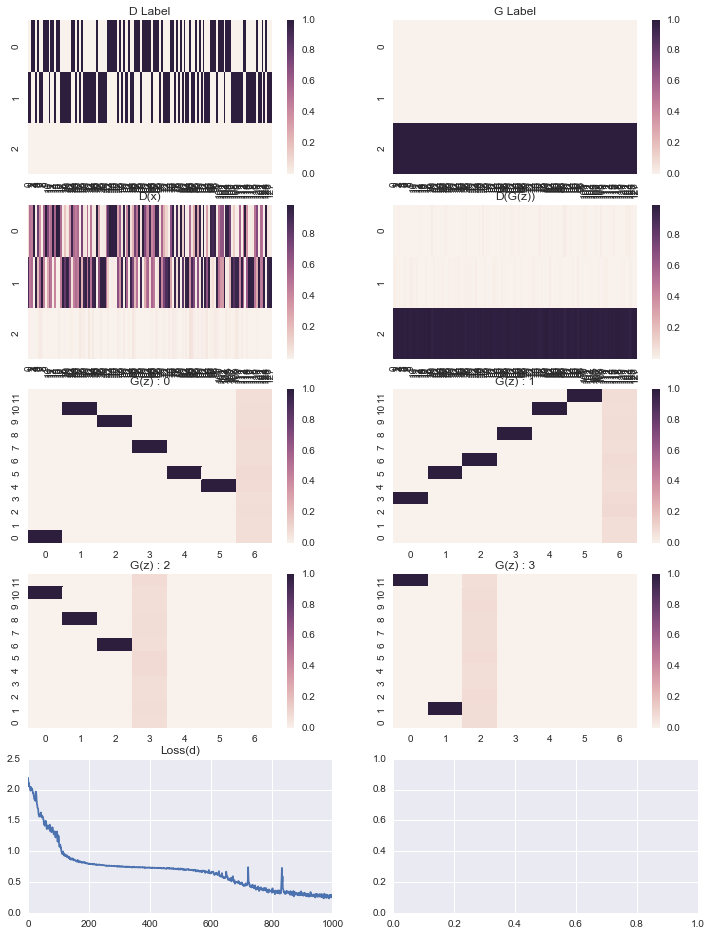

In [75]:
# Pre training
n_d_epochs_pre = int(1e3)
d_losses_pre = []
folderpath = 'gan_pre_{}_dlr_{}_glr_{}_bs_{}_temp_{}'.format(
    n_d_epochs_pre, d_specs['learning_rate'], g_specs['learning_rate'], d_batch_size, temperature)

if not os.path.exists(os.path.join('images', folderpath)):
    os.makedirs(os.path.join('images', folderpath))
        
for i in range(n_d_epochs_pre):
    d_X, _,  d_M, d_L = sample_data_batch(d_specs['batch_size'], input_data, target_data, masks_data, lbls_data)
    g_D, g_Z, g_C, g_M, g_L = sample_generator_batch(g_specs['batch_size'], input_data, cond_data, masks_data)
    d_loss, d_x_loss, d_g_z_loss, d_x, d_g_z, g_in_D_alt = d_train_fn(d_X, d_M, g_D, g_Z, g_C, g_M, d_L, g_L, 
                                                                      d_specs['learning_rate_pre'])
    d_losses_pre.append(d_loss)
    if i == (n_d_epochs_pre -1):
        fig, axes = plt.subplots(5, 2, figsize=(12, 16))
        axes[0, 0].set_title('D Label')
        sbn.heatmap(d_L.T, ax=axes[0, 0])
        axes[0, 1].set_title('G Label')
        sbn.heatmap(g_L.T, ax=axes[0, 1])

        axes[1, 0].set_title('D(x)')
        sbn.heatmap(d_x.T, ax=axes[1, 0])
        axes[1, 1].set_title('D(G(z))')        
        sbn.heatmap(d_g_z.T, ax=axes[1, 1])

        axes[2, 0].set_title('G(z) : 0')
        axes[2, 1].set_title('G(z) : 1')
        axes[3, 0].set_title('G(z) : 2')
        axes[3, 1].set_title('G(z) : 3')        
        sbn.heatmap(g_in_D_alt[0].T, ax=axes[2, 0]).invert_yaxis()
        sbn.heatmap(g_in_D_alt[1].T, ax=axes[2, 1]).invert_yaxis()
        sbn.heatmap(g_in_D_alt[2].T, ax=axes[3, 0]).invert_yaxis()
        sbn.heatmap(g_in_D_alt[3].T, ax=axes[3, 1]).invert_yaxis()        

        axes[4, 0].set_title('Loss(d)')                        
        axes[4, 0].plot(d_losses_pre)
        fig.savefig('images/{}/pre_training'.format(folderpath))

 14%|█▍        | 6900/50000 [15:13<26:50, 26.76it/s]


KeyboardInterrupt: 

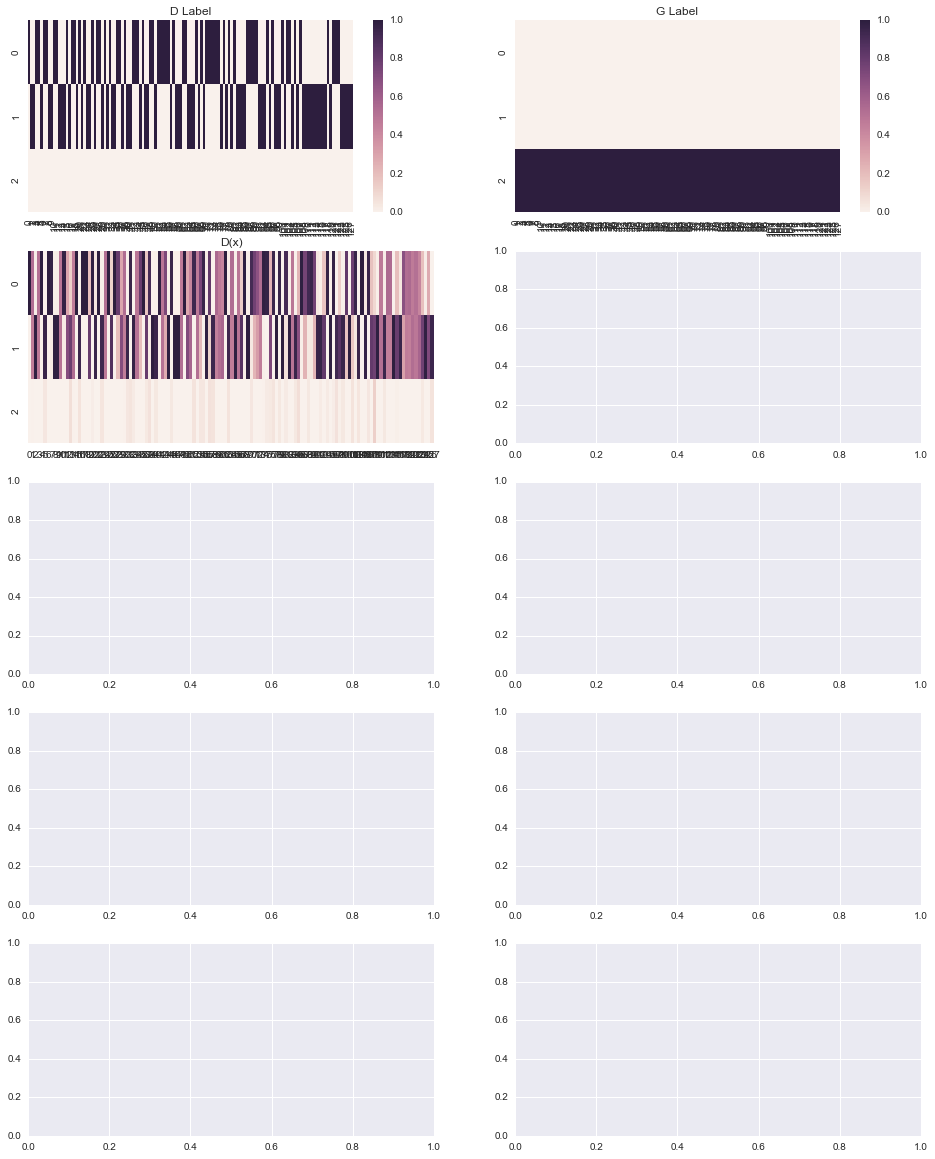

In [76]:
## store losses
d_losses = []
g_losses = []

n_epochs = int(5e4)
n_d_epochs = 1
n_g_epochs = 1

for epoch in tqdm(range(n_epochs)):
    for i in range(n_d_epochs):
        d_X, _,  d_M, d_L = sample_data_batch(d_specs['batch_size'], input_data, target_data, masks_data, lbls_data)
        g_D, g_Z, g_C, g_M, g_L = sample_generator_batch(g_specs['batch_size'], input_data, cond_data, masks_data)
        d_loss, d_x_loss, d_g_z_loss, d_x, d_g_z, g_in_D_alt = d_train_fn(
            d_X, d_M, g_D, g_Z, g_C, g_M, d_L, g_L, d_specs['learning_rate'])
        d_losses.append(d_loss)
        
    for i in range(n_g_epochs):
        g_D, g_Z, g_C, g_M, g_L = sample_generator_batch(g_specs['batch_size'], input_data, cond_data, masks_data)
        g_loss = g_train_fn(g_D, g_Z, g_C, g_M, g_L, g_specs['learning_rate'])
        g_losses.append(g_loss)

    if epoch % 100 == 0:
        fig, axes = plt.subplots(5, 2, figsize=(16, 20))
        axes[0, 0].set_title('D Label')
        sbn.heatmap(d_L.T, ax=axes[0, 0])
        axes[0, 1].set_title('G Label')
        sbn.heatmap(g_L.T, ax=axes[0, 1])
        
        axes[1, 0].set_title('D(x)')
        sbn.heatmap(d_x.T, ax=axes[1, 0])
        axes[1, 1].set_title('D(G(z))')        
        sbn.heatmap(d_g_z.T, ax=axes[1, 1])
        
        axes[2, 0].set_title('G(z) : 0')
        axes[2, 1].set_title('G(z) : 1')
        axes[3, 0].set_title('G(z) : 2')
        axes[3, 1].set_title('G(z) : 3')        
        sbn.heatmap(g_in_D_alt[0].T, ax=axes[2, 0]).invert_yaxis()
        sbn.heatmap(g_in_D_alt[1].T, ax=axes[2, 1]).invert_yaxis()
        sbn.heatmap(g_in_D_alt[2].T, ax=axes[3, 0]).invert_yaxis()
        sbn.heatmap(g_in_D_alt[3].T, ax=axes[3, 1]).invert_yaxis()        
        
        axes[4, 0].set_title('Loss(d)')                        
        axes[4, 0].plot(d_losses)
        axes[4, 1].set_title('Loss(g)')                        
        axes[4, 1].plot(g_losses)
        
        fig.savefig('images/{}/epoch_{}'.format(folderpath, epoch))
        plt.close('all') 
    
        display.clear_output(wait=True)